In [2]:
import cv2 as cv
from matplotlib import pyplot as plt 
from os import listdir
import numpy as np
import pandas as pd

from numpy import genfromtxt
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
import time

#import logging  # Setting up the loggings to monitor gensim
#logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import seaborn as sns

from keras.applications import VGG16
from keras.utils import load_img, img_to_array 
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, Sequential

from sklearn.decomposition import PCA

import plotly.express as px

import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

import plotly.io as pio
pio.renderers.default='notebook'

#from plotly.subplots import make_subplots
#import plotly.graph_objects as go

# Importation du nom des images

In [3]:
pictures_path =r'C:\Users\utilisateur\Desktop\OpenClassrooms\Projet6\Flipkart\Images'
liste_image_name = listdir(pictures_path)

# Importation des catégories de chaque image

In [4]:
fields = ['product_category_tree','image'] #colonnes à importer
path = r"C:\Users\utilisateur\Desktop\OpenClassrooms\Projet6\Flipkart\flipkart_com-ecommerce_sample_1050.csv"
df_cat = pd.read_csv(path, skipinitialspace=True, usecols=fields)
df_cat['product_category_tree'] = pd.Series([sentence[2:].rsplit(">>")[0].strip() for sentence in df_cat['product_category_tree']])
categ = df_cat['product_category_tree'].unique() #valeurs uniques des categories

In [5]:
#df_cat.groupby(['image','product_category_tree']).size().index # image avec catégorie
#récupérer categorie par image 
df = pd.DataFrame.from_records(df_cat.groupby(['image','product_category_tree']).size().index, columns=['image', 'class'])

In [6]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(tsne,features,categ) : # modification categ => rajouté
    #df_tsne['class'].apply(lambda x: np.where(df_tsne['class'].unique() == x)[0][0])
    ''' 
    Parameters :
    -----------
    |tsne : (boolean) if true pas besoin de le refaire car déjà fait sinon faire
    |features : (n,m) n = nombre d'images, m nombre de features vecteurs extraits des images  
    |categ : (liste ou colonne) nombre de catégories que possède le jeu de données (différent pour histogramme)
    
    Return :
    -----------
    |ARI : score ari avec catégories réelles et kmeans créé à partir des données et du nombre de catégories uniques
    |X_tsne : données après transformation en tsne (2 composantes)
    |cls.labels_ : clusters d'appartenance chaque données 
    
    
    '''
    label_true = categ.apply(lambda x: np.where(categ.unique() == x)[0][0])  # de string à numérique
    num_labels=len(set(label_true)) #nombre de catégories vraies uniques
    time1 = time.time()
    
    if tsne == False :
    
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                     init='random', learning_rate=200, random_state=42)
        X_tsne = tsne.fit_transform(features)
        print('X_tsne training done')
    else :
        X_tsne = features.to_numpy() # déjà transformé
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(label_true, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(title,X_tsne, true_categ, labels, ARI=None) :
    '''
    Parameters :
    -----------
    
    title : nom du sujet sur lequel l\'étude est menée
    X_tsne : données traitées par tsne sous forme tsne1 et tsne2,
    true_categ : véritables catégories prédéfinies
    labels : catégories trouvées par le modèle (O,n)
    
    Return :
    -----------
    
    
    
    '''
     #label_true = categ.apply(lambda x: np.where(categ.unique() == x)[0][0])
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=true_categ.apply(lambda x: np.where(true_categ.unique() == x)[0][0]), cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=true_categ.unique().tolist(), loc="best", title="Categorie")
    plt.title(f'Représentation des {title} par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title(f'Représentation des {title} par clusters')
    
    plt.show()
    print("ARI : ", ARI)


## Redimensionnement des images VGG16

In [7]:
def getFeatureVector(model, img_path):
  img = cv.imread(img_path)
  img = cv.resize(img, (224, 224))
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # du format de pillow à celui accepté par KERAS

  feature_vector = model.predict(img.reshape(1, 224, 224, 3))
  return feature_vector

# VGG16

In [8]:
#définition des parametres d'entrée de l'image en couleurs
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)

# Make all layers untrainable
for layer in vgg_model.layers[:]:
  layer.trainable = False

In [9]:
# Add fully connected layer which have 1024 neuron to VGG-16 model
output = vgg_model.get_layer('fc2').output # C4EST QUOI UN FULL CONNECTED LAYER 
output = Flatten(name='new_flatten')(output) # flatten réduire tout à plat
output = Dense(units=1024, activation='relu', name='new_fc')(output) # pourquoi fonction d'activation ? 
vgg_model = Model(vgg_model.input, output)

## Architecture

In [10]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
time0 = time.time()
features_vgg16 = np.zeros((1,1024))
for img_in_liste in liste_image_name:# récupérer chacune des images une par une 
    vector = getFeatureVector(vgg_model, pictures_path+'\\'+img_in_liste) # récupérer le vecteur des features
    features_vgg16 = np.concatenate((features_vgg16,vector), axis = 0) #ajouter les features de chaque vecteur
    print(features_vgg16.shape) #
features_vgg16 =np.delete(features_vgg16,0, axis=0) # suppression ligne de 0 du début
print(f'temps d\'exécution {np.round(time.time()-time0,0)}')

1/1 [==============================] - 2s 2s/step
(2, 1024)
1/1 [==============================] - 1s 895ms/step
(3, 1024)
1/1 [==============================] - 1s 577ms/step
(4, 1024)
1/1 [==============================] - 1s 538ms/step
(5, 1024)
1/1 [==============================] - 1s 684ms/step
(6, 1024)
1/1 [==============================] - 1s 642ms/step
(7, 1024)
1/1 [==============================] - 1s 658ms/step
(8, 1024)
1/1 [==============================] - 1s 544ms/step
(9, 1024)
1/1 [==============================] - 1s 587ms/step
(10, 1024)
1/1 [==============================] - 1s 569ms/step
(11, 1024)
1/1 [==============================] - 1s 577ms/step
(12, 1024)
1/1 [==============================] - 1s 560ms/step
(13, 1024)
1/1 [==============================] - 1s 596ms/step
(14, 1024)
1/1 [==============================] - 1s 519ms/step
(15, 1024)
1/1 [==============================] - 1s 647ms/step
(16, 1024)
1/1 [==============================] - 1s 563ms/ste

1/1 [==============================] - 1s 664ms/step
(130, 1024)
1/1 [==============================] - 1s 900ms/step
(131, 1024)
1/1 [==============================] - 1s 668ms/step
(132, 1024)
1/1 [==============================] - 1s 639ms/step
(133, 1024)
1/1 [==============================] - 1s 707ms/step
(134, 1024)
1/1 [==============================] - 1s 717ms/step
(135, 1024)
1/1 [==============================] - 1s 738ms/step
(136, 1024)
1/1 [==============================] - 1s 790ms/step
(137, 1024)
1/1 [==============================] - 1s 721ms/step
(138, 1024)
1/1 [==============================] - 1s 764ms/step
(139, 1024)
1/1 [==============================] - 1s 739ms/step
(140, 1024)
1/1 [==============================] - 1s 723ms/step
(141, 1024)
1/1 [==============================] - 1s 719ms/step
(142, 1024)
1/1 [==============================] - 1s 730ms/step
(143, 1024)
1/1 [==============================] - 1s 670ms/step
(144, 1024)
1/1 [====================

1/1 [==============================] - 1s 654ms/step
(382, 1024)
1/1 [==============================] - 1s 743ms/step
(383, 1024)
1/1 [==============================] - 1s 637ms/step
(384, 1024)
1/1 [==============================] - 1s 680ms/step
(385, 1024)
1/1 [==============================] - 1s 682ms/step
(386, 1024)
1/1 [==============================] - 1s 843ms/step
(387, 1024)
1/1 [==============================] - 1s 733ms/step
(388, 1024)
1/1 [==============================] - 1s 746ms/step
(389, 1024)
1/1 [==============================] - 1s 784ms/step
(390, 1024)
1/1 [==============================] - 1s 818ms/step
(391, 1024)
1/1 [==============================] - 1s 850ms/step
(392, 1024)
1/1 [==============================] - 1s 924ms/step
(393, 1024)
1/1 [==============================] - 1s 717ms/step
(394, 1024)
1/1 [==============================] - 1s 763ms/step
(395, 1024)
1/1 [==============================] - 1s 718ms/step
(396, 1024)
1/1 [====================

1/1 [==============================] - 1s 673ms/step
(634, 1024)
1/1 [==============================] - 1s 715ms/step
(635, 1024)
1/1 [==============================] - 1s 677ms/step
(636, 1024)
1/1 [==============================] - 1s 721ms/step
(637, 1024)
1/1 [==============================] - 1s 713ms/step
(638, 1024)
1/1 [==============================] - 1s 661ms/step
(639, 1024)
1/1 [==============================] - 1s 747ms/step
(640, 1024)
1/1 [==============================] - 1s 611ms/step
(641, 1024)
1/1 [==============================] - 1s 702ms/step
(642, 1024)
1/1 [==============================] - 1s 725ms/step
(643, 1024)
1/1 [==============================] - 1s 721ms/step
(644, 1024)
1/1 [==============================] - 1s 674ms/step
(645, 1024)
1/1 [==============================] - 1s 713ms/step
(646, 1024)
1/1 [==============================] - 1s 659ms/step
(647, 1024)
1/1 [==============================] - 1s 711ms/step
(648, 1024)
1/1 [====================

1/1 [==============================] - 1s 868ms/step
(761, 1024)
1/1 [==============================] - 1s 1s/step
(762, 1024)
1/1 [==============================] - 1s 941ms/step
(763, 1024)
1/1 [==============================] - 1s 909ms/step
(764, 1024)
1/1 [==============================] - 1s 1s/step
(765, 1024)
1/1 [==============================] - 1s 962ms/step
(766, 1024)
1/1 [==============================] - 1s 845ms/step
(767, 1024)
1/1 [==============================] - 1s 941ms/step
(768, 1024)
1/1 [==============================] - 1s 939ms/step
(769, 1024)
1/1 [==============================] - 1s 902ms/step
(770, 1024)
1/1 [==============================] - 1s 869ms/step
(771, 1024)
1/1 [==============================] - 1s 994ms/step
(772, 1024)
1/1 [==============================] - 1s 991ms/step
(773, 1024)
1/1 [==============================] - 1s 882ms/step
(774, 1024)
1/1 [==============================] - 1s 936ms/step
(775, 1024)
1/1 [==========================

1/1 [==============================] - 1s 1s/step
(1015, 1024)
1/1 [==============================] - 1s 960ms/step
(1016, 1024)
1/1 [==============================] - 1s 841ms/step
(1017, 1024)
1/1 [==============================] - 1s 864ms/step
(1018, 1024)
1/1 [==============================] - 1s 975ms/step
(1019, 1024)
1/1 [==============================] - 1s 1s/step
(1020, 1024)
1/1 [==============================] - 1s 1s/step
(1021, 1024)
1/1 [==============================] - 1s 1s/step
(1022, 1024)
1/1 [==============================] - 1s 1s/step
(1023, 1024)
1/1 [==============================] - 1s 964ms/step
(1024, 1024)
1/1 [==============================] - 1s 1s/step
(1025, 1024)
1/1 [==============================] - 1s 1s/step
(1026, 1024)
1/1 [==============================] - 1s 997ms/step
(1027, 1024)
1/1 [==============================] - 1s 942ms/step
(1028, 1024)
1/1 [==============================] - 1s 989ms/step
(1029, 1024)
1/1 [==========================

## PCA 

In [12]:
print("Dimensions dataset avant réduction PCA : ", features_vgg16.shape)
pca_vgg16 = PCA(n_components = 0.99) #initialisation du PCA et 
features_pca_vgg16 = pca_vgg16.fit_transform(features_vgg16)
print("Dimensions dataset après réduction PCA : ", features_pca_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 1024)
Dimensions dataset après réduction PCA :  (1050, 621)


## Tsne  + ajout de la catégorie 

In [15]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
vgg16_tsne = tsne.fit_transform(features_pca_vgg16)

df_vgg16_tsne = pd.DataFrame(vgg16_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_vgg16_tsne["class"] = df['class']#df_cat["product_category_tree"] erreur puisque 53000 lignes choisis les premieres 1050 lignes
print(df_vgg16_tsne.shape)

C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(1050, 3)


In [16]:
df_vgg16_tsne.groupby(['class']).agg({'tsne1':['sum','median','mean'],'tsne2':['sum','median','mean']})

tsne1                              tsne2  \
                                    sum     median       mean          sum   
class                                                                        
Baby Care                  -1635.958984 -13.383897 -10.906393  3185.370850   
Beauty and Personal Care    1069.260864   8.002968   7.128406 -4067.068848   
Computers                   2269.022949  15.143095  15.126820  -635.739258   
Home Decor & Festive Needs -1286.696899 -11.414413  -8.577979   385.178436   
Home Furnishing            -1912.616211 -12.471077 -12.750774  3084.847412   
Kitchen & Dining           -1830.747559 -14.242237 -12.204984 -3485.308105   
Watches                     5578.293457  39.249943  37.188622  1489.974976   

                                                  
                               median       mean  
class                                             
Baby Care                   24.653107  21.235806  
Beauty and Personal Care   -34.843346 -27.113792  
Computers                   -5.972681  -4.238262  
Home Decor & Festive Needs   1.312554   2.567856  
Home Furnishing             21.165611  20.565649  
Kitchen & Dining           -29.864729 -23.235388  
Watches                     11.042189   9.933167

## Distribution 

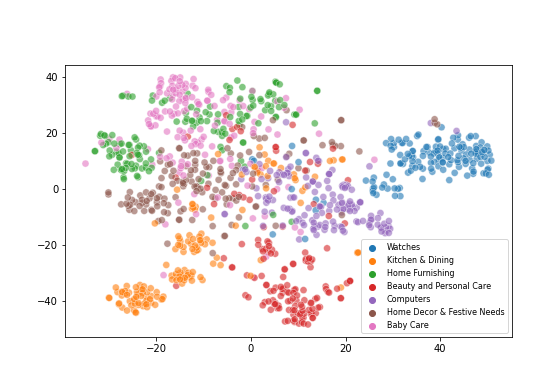

In [20]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_vgg16_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold', color='white')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold', color='white')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold', color='white')
plt.legend(prop={'size': 8}) 

plt.show()

## Affichage catégorie

In [21]:
 df_vgg16_tsne.iloc[:,2].unique()

array(['Watches', 'Kitchen & Dining', 'Home Furnishing',
       'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Baby Care'], dtype=object)

ARI :  0.4465 time :  3.0


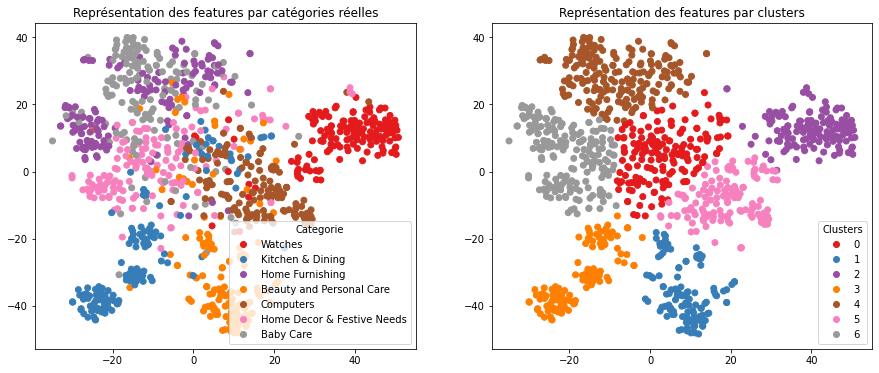

ARI :  0.4465


In [22]:
#ari avec 
title = "features"
ARI, X_tsne, labels = ARI_fct(features = df_vgg16_tsne.iloc[:,:2],categ= df_vgg16_tsne.iloc[:,2], tsne=True) # meme nombre de clusterings que sift pour comparer
TSNE_visu_fct(title,X_tsne,df_vgg16_tsne['class'], labels, ARI)